# Initialization

Load data

In [1]:
import pickle


# Label to use for this model in the plots
model_name = 'GP'

with open('../../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train = splits['docs_train']
docs_val = splits['docs_val']
fingerprints_train_raw = splits['fingerprints_train']
fingerprints_val_raw = splits['fingerprints_val']
targets_train = splits['targets_train']
targets_val = splits['targets_val']

# Define all the adsorbates
adsorbates = list({doc['adsorbate'] for doc in docs_val})
adsorbates.sort()

Scale the fingerprints and format the data

In [2]:
from sklearn.preprocessing import StandardScaler
import torch


# Scale the fingerprints
scaler = StandardScaler()
fingerprints_train = scaler.fit_transform(fingerprints_train_raw)
fingerprints_val = scaler.transform(fingerprints_val_raw)

# Convert everything to Tensors for GPyTorch
fingerprints_train = torch.Tensor(fingerprints_train).contiguous()
fingerprints_val = torch.Tensor(fingerprints_val)
targets_train = torch.Tensor(targets_train.reshape(-1))
targets_val = torch.Tensor(targets_val.reshape(-1))

Define an exact GP

# Training GP
We tried using an exact GP with a CPU, but it took too long and never converged. We then tried an exact GP with a GPU, but we did not have enough memory in the GPU to hold both the data and the kernel. Finally, we tried using 3 GPUs (each with 16 GB of memory). This finally worked.

In order to use 3 GPUs, we needed to run a Python script instead of a Jupyter notebook (because of logistical reasons on our high-performance computers). Here is what that python script contains:

```
import gc
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import gpytorch
from LBFGS import FullBatchLBFGS


# Verify the number of GPUs
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))
output_device = torch.device('cuda:0')

# Pull training data
with open('../../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train = splits['docs_train']
docs_val = splits['docs_val']
fingerprints_train_raw = splits['fingerprints_train']
fingerprints_val_raw = splits['fingerprints_val']
targets_train = splits['targets_train']
targets_val = splits['targets_val']
adsorbates = list({doc['adsorbate'] for doc in docs_val})
adsorbates.sort()

# Scale the fingerprints
scaler = StandardScaler()
fingerprints_train = scaler.fit_transform(fingerprints_train_raw)
fingerprints_val = scaler.transform(fingerprints_val_raw)

# Convert everything to Tensors for GPyTorch
fingerprints_train = torch.Tensor(fingerprints_train).contiguous()
fingerprints_val = torch.Tensor(fingerprints_val)
targets_train = torch.Tensor(targets_train.reshape(-1))
targets_val = torch.Tensor(targets_val.reshape(-1))

# Make the targets contiguous...?
targets_train, targets_val = targets_train.contiguous(), targets_val.contiguous()
# Move them to the GPU
fingerprints_train, targets_train = fingerprints_train.to(output_device), targets_train.to(output_device)
fingerprints_val, targets_val = fingerprints_val.to(output_device), targets_val.to(output_device)


# Define GP
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Define training routine
def train(train_x, train_y,
          n_devices, output_device,
          checkpoint_size, preconditioner_size,
          n_training_iter):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
    model = ExactGPModel(train_x, train_y, likelihood, n_devices).to(output_device)
    model.train()
    likelihood.train()

    optimizer = FullBatchLBFGS(model.parameters(), lr=0.1)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
         gpytorch.settings.max_preconditioner_size(preconditioner_size):

        def closure():
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            return loss

        loss = closure()
        loss.backward()

        for i in range(n_training_iter):
            options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
            loss, _, _, _, _, _, _, fail = optimizer.step(options)

            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, n_training_iter, loss.item(),
                model.covar_module.module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))

            if fail:
                print('Convergence reached!')
                break

    print(f"Finished training on {train_x.size(0)} data points using {n_devices} GPUs.")
    return model, likelihood


# Define routine for getting GPU settings
def find_best_gpu_setting(train_x, train_y,
                          n_devices, output_device,
                          preconditioner_size):
    N = train_x.size(0)

    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            _, _ = train(train_x, train_y,
                         n_devices=n_devices, output_device=output_device,
                         checkpoint_size=checkpoint_size,
                         preconditioner_size=preconditioner_size, n_training_iter=1)

            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size


# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(fingerprints_train, targets_train,
                                        n_devices=n_devices,
                                        output_device=output_device,
                                        preconditioner_size=preconditioner_size)

# Fit and save the model
model, likelihood = train(fingerprints_train, targets_train,
                          n_devices=n_devices, output_device=output_device,
                          checkpoint_size=10000,
                          preconditioner_size=100,
                          n_training_iter=20)
torch.save(model.state_dict(), 'model_state.pth')

# Make and save the predictions
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(1000):
    preds = model(fingerprints_val)
targets_pred = preds.mean
targets_std = preds.stddev.detach().cpu().numpy()
residuals = (targets_pred - targets_val).detach().cpu().numpy()
with open('predictions.pkl', 'wb') as file_handle:
    pickle.dump((residuals, targets_std), file_handle)
```

And here is the output:
```
Planning to run on 3 GPUs.
Number of devices: 3 -- Kernel partition size: 0
Iter 1/1 - Loss: 0.711   lengthscale: 1.240   noise: 0.053
Finished training on 32359 data points using 3 GPUs.
Iter 1/20 - Loss: 0.709   lengthscale: 1.241   noise: 0.053
Iter 2/20 - Loss: 0.694   lengthscale: 1.198   noise: 0.058
Iter 3/20 - Loss: 0.682   lengthscale: 1.174   noise: 0.063
Iter 4/20 - Loss: 0.661   lengthscale: 1.168   noise: 0.065
Iter 5/20 - Loss: 0.676   lengthscale: 1.168   noise: 0.065
Convergence reached!
Finished training on 32359 data points using 3 GPUs.
```

Now we load the results

In [3]:
import pickle


with open('predictions.pkl', 'rb') as file_handle:
    residuals, stdevs = pickle.load(file_handle)

# Assess performance
## All adsorbates
This latest chunk of data came from multiple adsorbates. To start simple, let's just plot everything within a single pool.

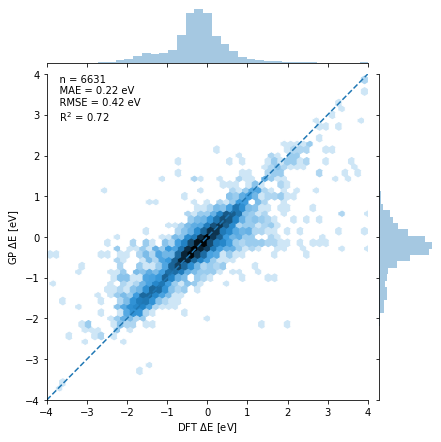

In [4]:
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


# Parse the predictions
targets_pred = targets_val.numpy().reshape(-1) + residuals

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
r2 = r2_score(targets_val, targets_pred)

# Report
text = ('    n = %i\n'
        '    MAE = %.2f eV\n'
        '    RMSE = %.2f eV\n'
        '    R$^2$ = %.2f'
        % (len(targets_val), mae, rmse, r2))
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

In [5]:
%load_ext ipycache

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [6]:
%%cache calibration.pkl predicted_pi observed_pi

import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


def calculate_density(percentile):
    num_within_quantile = 0
    for stdev, resid in zip(stdevs, residuals):
        norm = stats.norm(loc=0, scale=stdev)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

[Saved variables 'observed_pi, predicted_pi' to file '/global/project/projectdirs/m2755/ktran/sandbox/uncertainty_benchmarking/GP/Matern/calibration.pkl'.]



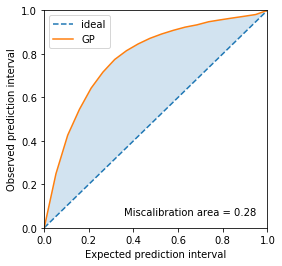

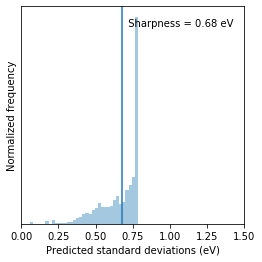

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
miscalibration_area = polygon.area

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right')

# Plot sharpness curve
xlim = [0., 1.5]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align)

## Results-by-adsorbate
Let's dig into details and see how our results turned out for each adsorbate. Note that this section shows the results from a single model trained on a pooled dataset. Only the performance metrics are partitioned by adsorbate.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np


class SeabornFig2Grid():
    '''
    Credit goes to ImportanceOfBeingErnest on StackOverflow
    https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
    '''

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

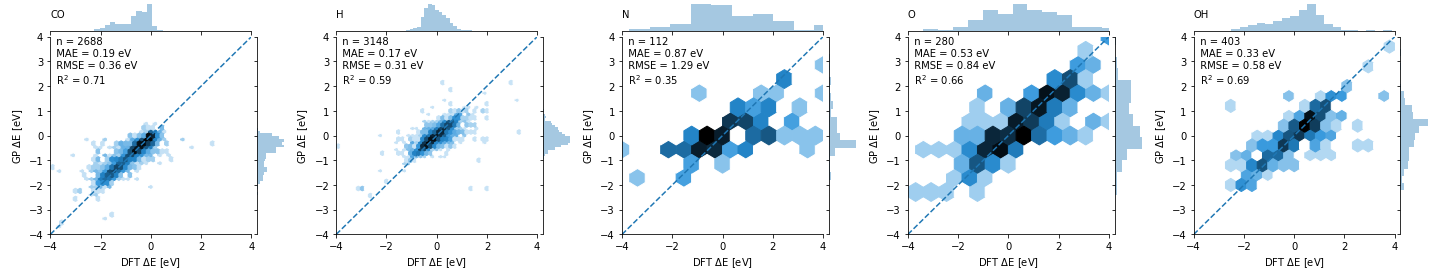

In [9]:
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


# Prepare figure for all adsorbates
fig = plt.figure(figsize=(20, 4))
gs = gridspec.GridSpec(1, len(adsorbates))

# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _targets_val = []
    _targets_pred = []
    for doc, target, pred in zip(docs_val, targets_val, targets_pred):
        if doc['adsorbate'] == ads:
            _targets_val.append(target)
            _targets_pred.append(pred)
    _targets_val = np.array(_targets_val).reshape(-1)
    _targets_pred = np.array(_targets_pred).reshape(-1)

    # Plot accuracy
    lims = [-4, 4]
    grid = sns.jointplot(_targets_val, _targets_pred,
                         kind='hex',
                         bins='log',
                         extent=lims*2)
    ax = grid.ax_joint
    _ = ax.set_xlim(lims)
    _ = ax.set_ylim(lims)
    _ = ax.plot(lims, lims, '--')
    _ = ax.set_xlabel('DFT $\Delta$E [eV]')
    _ = ax.set_ylabel('GP $\Delta$E [eV]')
    _ = ax.set_title(ads)

    # Calculate + report metrics
    mae = mean_absolute_error(_targets_val, _targets_pred)
    rmse = np.sqrt(mean_squared_error(_targets_val, _targets_pred))
    r2 = r2_score(_targets_val, _targets_pred)
    grid.ax_marg_x.text(x=lims[0], y=0,
                        verticalalignment='bottom',
                        s='%s\n' % ads)
    text = ('  n = %i\n'
            '  MAE = %.2f eV\n'
            '  RMSE = %.2f eV\n'
            '  R$^2$ = %.2f'
            % (len(_targets_val), mae, rmse, r2))
    ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

    # Put the figure into the subplot
    sfg = SeabornFig2Grid(grid, fig, gs[i])
gs.tight_layout(fig)

In [10]:
%%cache calibration_blocked.pkl predicted_pi observed_pi

import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


# Create a function that we'll use to calculate calibration curves
def calculate_density(percentile, residuals, stdevs):
    num_within_quantile = 0
    for stdev, resid in zip(stdevs, residuals):
        norm = stats.norm(loc=0, scale=stdev)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

# Initialize the information we need to make calibration plots
predicted_pi = {}
observed_pi = {}

# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _residuals = []
    _stdevs = []
    for doc, resid, se in zip(docs_val, residuals, stdevs):
        if doc['adsorbate'] == ads:
            _residuals.append(resid)
            _stdevs.append(se)
    _residuals = np.array(_residuals).reshape(-1)
    _stdevs = np.array(_stdevs).reshape(-1)

    # Calculate the prediction intervals
    _predicted_pi = np.linspace(0, 1, 20)
    _observed_pi = [calculate_density(quantile, _residuals, _stdevs)
                    for quantile in tqdm_notebook(_predicted_pi, desc='Calibration')]

    # Store the information
    predicted_pi[ads] = _predicted_pi
    observed_pi[ads] = _observed_pi

[Saved variables 'observed_pi, predicted_pi' to file '/global/project/projectdirs/m2755/ktran/sandbox/uncertainty_benchmarking/GP/Matern/calibration_blocked.pkl'.]







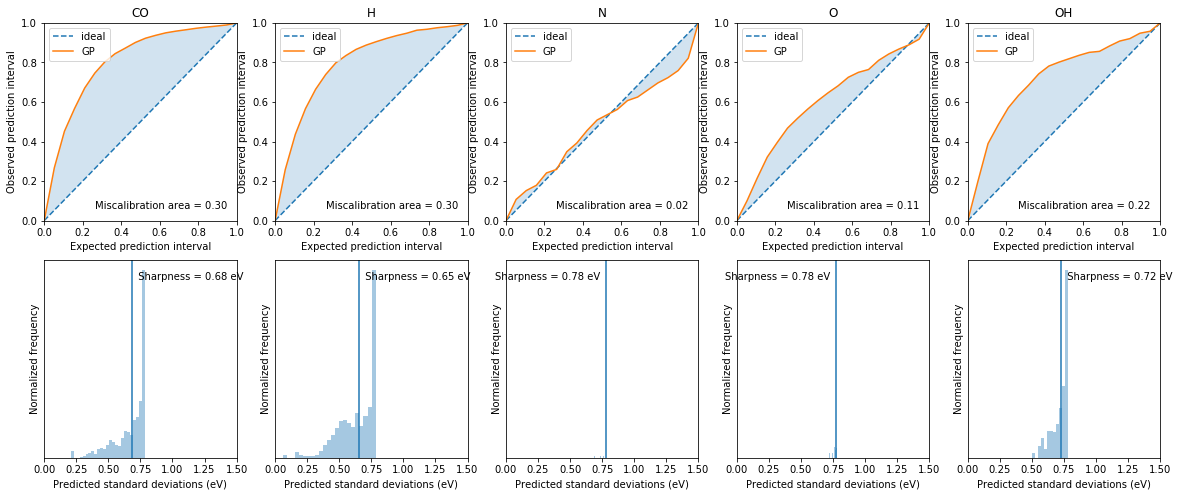

In [11]:
%matplotlib inline
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon


# Prepare figure for all adsorbates
figsize = (20, 8)
fig, axes = plt.subplots(2, len(adsorbates), figsize=figsize)
sub_figsize = (figsize[0]/len(adsorbates), figsize[1]/2)


# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _stdevs = []
    for doc, stdev in zip(docs_val, stdevs):
        if doc['adsorbate'] == ads:
            _stdevs.append(stdev)
    _stdevs = np.array(_stdevs).reshape(-1)
    _observed_pi = observed_pi[ads]
    _predicted_pi = predicted_pi[ads]

    # Plot the calibration curve
    ax_cal = axes[0][i]
    ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal', ax=ax_cal)
    _ = ax_ideal.lines[0].set_linestyle('--')
    ax_gp = sns.lineplot(_predicted_pi, _observed_pi, label=model_name, ax=ax_cal)
    ax_fill = ax_cal.fill_between(_predicted_pi, _predicted_pi, _observed_pi,
                                  alpha=0.2)
    _ = ax_ideal.set_xlabel('Expected prediction interval')
    _ = ax_ideal.set_ylabel('Observed prediction interval')
    _ = ax_ideal.set_xlim([0, 1])
    _ = ax_ideal.set_ylim([0, 1])
    _ = ax_cal.legend(loc='upper left')
    _ = ax_cal.set_title(ads)

    # Calculate the miscalibration area.
    polygon_points = []
    for point in zip(_predicted_pi, _observed_pi):
        polygon_points.append(point)
    for point in zip(reversed(_predicted_pi), reversed(_predicted_pi)):
        polygon_points.append(point)
    polygon_points.append((_predicted_pi[0], _observed_pi[0]))
    polygon = Polygon(polygon_points)
    miscalibration_area = polygon.area

    # Annotate the plot with the miscalibration area
    ax_cal.text(x=0.95, y=0.05,
                s='Miscalibration area = %.2f' % miscalibration_area,
                verticalalignment='bottom',
                horizontalalignment='right')

    # Plot sharpness curve
    xlim = [0., 1.5]
    ax_sharp = axes[1][i]
    ax_sharp = sns.distplot(_stdevs, kde=False, norm_hist=True, ax=ax_sharp)
    ax_sharp.set_xlim(xlim)
    ax_sharp.set_xlabel('Predicted standard deviations (eV)')
    ax_sharp.set_ylabel('Normalized frequency')
    ax_sharp.set_yticklabels([])
    ax_sharp.set_yticks([])

    # Calculate and report sharpness
    sharpness = np.sqrt(np.mean(_stdevs**2))
    _ = ax_sharp.axvline(x=sharpness, label='sharpness')
    if sharpness < (xlim[0] + xlim[1]) / 2:
        text = '\n  Sharpness = %.2f eV' % sharpness
        h_align = 'left'
    else:
        text = '\nSharpness = %.2f eV  ' % sharpness
        h_align = 'right'
    _ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                      s=text,
                      verticalalignment='top',
                      horizontalalignment=h_align)